# Sleep interruptions and our diet

#### Our predictor is sleep interruptions and our feature set contains elements such as calories, nutrients or late meals

1. Sleep data consists of bedtime, time it takes to fall asleep, mid night wake ups, final wake up time etc.

2. We also have data on the individual pertaining to what they ate through out the day and when they ate.

3. Preliminary phase of the notebook will be related to data cleansing and aggregation.

4. The model will use our feature set to predict interruptions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
%matplotlib inline

### Acquire data

The Python Pandas packages helps us work with our datasets. 

In [3]:
SleepData = pd.read_csv("Interruptions.csv")

In [4]:
diettrain = pd.read_csv("DietSleepTrainintake.csv")

### We convert our date argument into a datetime object

In [5]:
SleepData['calDate'] = pd.to_datetime(SleepData['calDate']).dt.date
diettrain['calDate'] = pd.to_datetime(diettrain['calDate']).dt.date

### We will deduct one day from calDate in the diet data frame

- The date in our diet data reflects the day after we slept
- By subtracting one day, our features will reflect that day's sleep rather than one day after
- We will join the two datasets sleep and diet according to date

In [6]:
diettrain['calDate'] = diettrain['calDate'] -  pd.to_timedelta(1, unit='d')

In [7]:
# preview the data
diettrain.tail()

,ProfileId,calDate,mealTime,mealType,nf_sugars,nf_total_carbohydrate,nf_potassium,nf_dietary_fiber,nf_sodium,nf_protein,nf_total_fat,nf_cholesterol,nf_calories,nf_saturated_fat
527,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-22,6:00 PM,dinner,0.06,2.64,45.88,0.11,105.28,4.53,6.51,21.95,87.74,2.31
528,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-22,6:00 PM,dinner,0.77,6.75,838.80,4.32,126.00,5.35,0.47,0.00,41.40,0.08
529,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-22,6:00 PM,dinner,3.42,6.35,360.18,2.70,45.24,1.08,0.17,0.00,26.97,0.08
530,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-22,6:00 PM,dinner,28.00,37.65,35.51,0.20,180.23,2.00,12.00,50.25,261.97,1.97
531,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-21,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
diettrain[diettrain.isna().any(axis=1)]
# There are 22 rows with null values

# We will drop the last row, because it all zeros
diettrain = diettrain[:-1]

#filling NA's with the mean of the column:
diettrain = diettrain.fillna(diettrain.mean())

### Summation of nutritional values Daily

- We created a truncated dataframe by dropping columns which will not be used in our model
- ProfileId, mealtime and mealtype are all dropped
- The aim is to get total nutrient intake during the whole day
- We group by date and then sum up the values

In [9]:
# TruncatedDiet = diettrain.drop(['ProfileId', 'mealTime', 'mealType'], axis=1)

# Not all features were used here for simplicity, though we will add them back
TruncatedDiet = diettrain[['calDate', 'nf_sugars','nf_total_carbohydrate', 'nf_calories']].copy()

In [10]:
TruncatedDiet.shape

(531, 4)

In [11]:
TruncatedDiet = TruncatedDiet.groupby(['calDate']).sum().reset_index()

TruncatedDiet.head()

# The number of rows drops 531 to 57 after summing all meals for each day

,calDate,nf_sugars,nf_total_carbohydrate,nf_calories
0,2022-05-22,54.530000,147.05,1176.04
1,2022-05-23,0.370000,0.76,180.32
2,2022-05-24,18.370000,129.76,1059.21
3,2022-05-25,98.790000,234.01,2191.93
4,2022-05-26,38.851404,144.60,1769.28


### Plot of the daily calorie intake 

Our data contains observayions with zeros


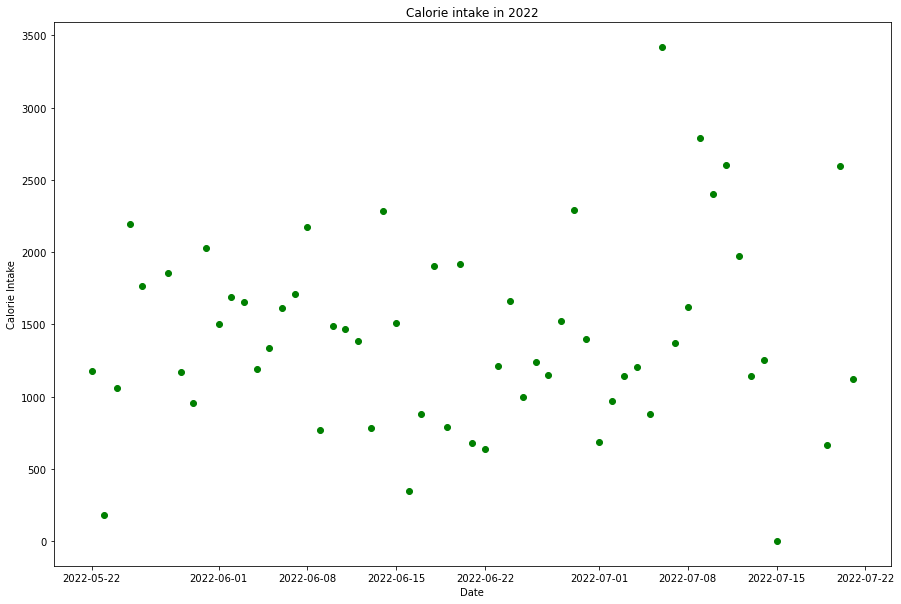

In [12]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(15, 10))

# Add x-axis and y-axis
ax.scatter(TruncatedDiet['calDate'],
        TruncatedDiet['nf_calories'],
        color='green')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Calorie Intake",
       title="Calorie intake in 2022")

plt.show()

### A histogram will be more explanatory

The mode appears towards 1500 calories, and the intake follows a Gaussian distribution

array([[<AxesSubplot:title={'center':'Daily Calories'}>]], dtype=object)

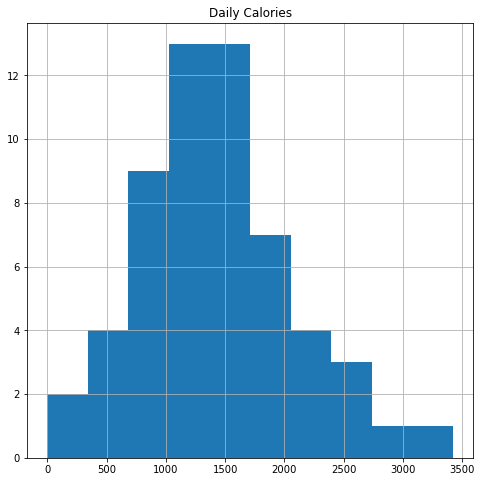

In [13]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
Calories = pd.DataFrame({"Daily Calories":TruncatedDiet['nf_calories']})
Calories.hist()

In [14]:
diettrain.dtypes
# We need to change mealType to string

ProfileId                 object
calDate                   object
mealTime                  object
mealType                  object
nf_sugars                float64
nf_total_carbohydrate    float64
nf_potassium             float64
nf_dietary_fiber         float64
nf_sodium                float64
nf_protein               float64
nf_total_fat             float64
nf_cholesterol           float64
nf_calories              float64
nf_saturated_fat         float64
dtype: object

### Creating dataframe for dinner meal only

- Keep mealtime to track duration from sleep
- We will drop all nutrients except dinner sugar and carbs
- Columns will be renamed to dinner sugar and dinner carbs
- We will not deduct these values from daily carb and sugar intake

In [15]:
diettrain['mealType'] = diettrain['mealType'].str.lower()
# convert object to string and remove capitilization

In [16]:
DinnerTrain = diettrain[diettrain['mealType'] == 'dinner'].copy()

In [17]:
DinnerTrain

,ProfileId,calDate,mealTime,mealType,nf_sugars,nf_total_carbohydrate,nf_potassium,nf_dietary_fiber,nf_sodium,nf_protein,nf_total_fat,nf_cholesterol,nf_calories,nf_saturated_fat
15,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-07-20,6:00 PM,dinner,3.66,9.73,295.10,4.16,43.46,2.38,0.46,0.00,45.30,0.08
16,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-07-20,6:00 PM,dinner,0.14,0.72,29.30,0.33,4.10,0.24,0.04,0.00,3.50,0.01
17,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-07-20,6:00 PM,dinner,11.96,23.63,816.50,13.23,86.25,10.58,2.59,0.00,132.25,0.40
18,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-07-20,6:00 PM,dinner,2.83,3.64,157.38,0.00,916.22,22.07,29.06,84.18,364.78,15.79
19,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-07-20,6:00 PM,dinner,1.59,3.78,108.10,1.38,26.68,0.35,0.08,0.00,16.10,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-24,6:00 PM,dinner,2.83,3.64,157.38,0.00,916.22,22.07,29.06,84.18,364.78,15.79
527,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-22,6:00 PM,dinner,0.06,2.64,45.88,0.11,105.28,4.53,6.51,21.95,87.74,2.31
528,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-22,6:00 PM,dinner,0.77,6.75,838.80,4.32,126.00,5.35,0.47,0.00,41.40,0.08
529,ab8edb37-6577-4879-80d8-eac44b53a97e,2022-05-22,6:00 PM,dinner,3.42,6.35,360.18,2.70,45.24,1.08,0.17,0.00,26.97,0.08


In [18]:
DinnerTrain = DinnerTrain[['calDate','mealTime', 'nf_sugars', 'nf_total_carbohydrate', 'nf_calories']]

DinnerTrain.head()

,calDate,mealTime,nf_sugars,nf_total_carbohydrate,nf_calories
15,2022-07-20,6:00 PM,3.66,9.73,45.30
16,2022-07-20,6:00 PM,0.14,0.72,3.50
17,2022-07-20,6:00 PM,11.96,23.63,132.25
18,2022-07-20,6:00 PM,2.83,3.64,364.78
19,2022-07-20,6:00 PM,1.59,3.78,16.10


In [19]:
DinnerTrain = DinnerTrain.groupby(['calDate', 'mealTime']).sum().reset_index()

In [20]:
DinnerTrain.head()

,calDate,mealTime,nf_sugars,nf_total_carbohydrate,nf_calories
0,2022-05-22,6:00 PM,32.25,53.39,418.08
1,2022-05-24,6:00 PM,4.74,52.44,596.11
2,2022-05-25,6:00 PM,63.38,126.72,1131.49
3,2022-05-26,6:00 PM,12.76,75.88,879.91
4,2022-05-28,6:00 PM,3.53,43.46,572.42


In [21]:
DinnerTrain.rename(columns = {'mealTime':'Dinner_time', 'nf_sugars':'Dinner_sugar', 'nf_total_carbohydrate':'Dinner_carbs', 'nf_calories':'Dinner_calories'}, inplace = True)
DinnerTrain.head()

,calDate,Dinner_time,Dinner_sugar,Dinner_carbs,Dinner_calories
0,2022-05-22,6:00 PM,32.25,53.39,418.08
1,2022-05-24,6:00 PM,4.74,52.44,596.11
2,2022-05-25,6:00 PM,63.38,126.72,1131.49
3,2022-05-26,6:00 PM,12.76,75.88,879.91
4,2022-05-28,6:00 PM,3.53,43.46,572.42


### Merging our two dataframes using caldate

- DinnerTrain and Diettrain have different observations
- Dinner has 48 observations while the daily diet has 56
- We left joined the data, so if there is no dinner, the right dataframe will be NaN

In [22]:
 MergedDiet = (pd.merge(TruncatedDiet, DinnerTrain, how='left', on='calDate'))

In [23]:
# replaced by the mode
#MergedDiet['Dinner_time'] = MergedDiet['Dinner_time'].fillna(MergedDiet['Dinner_time'].mode()[0])

# Locating rows with zero calories per day
# replacing the values in these rows by the mean
MergedDiet.loc[ MergedDiet['nf_calories'] == 0, ['nf_sugars', 'nf_total_carbohydrate', 'nf_calories']] = [MergedDiet['nf_sugars'].mean(),MergedDiet['nf_total_carbohydrate'].mean(),MergedDiet['nf_calories'].mean()]

# filling NA's with the mean of the column:
# There is a problem with this strategy
# Total calories per day no longer match with dinner 
MergedDiet = MergedDiet.fillna(MergedDiet.mean())

# The wrong time format will be replaced with the mode
# It is unfeasable to estimate the possible ways a date/time will be written wrong
MergedDiet['Dinner_time'] = pd.to_datetime(MergedDiet['Dinner_time'], 'coerce')
MergedDiet['Dinner_time'] = MergedDiet['Dinner_time'].fillna(MergedDiet['Dinner_time'].mode()[0])
#MergedDiet['Dinner_time'] = MergedDiet['Dinner_time'].apply(lambda x: x.strftime('%H:%M'))
MergedDiet.tail()

,calDate,nf_sugars,nf_total_carbohydrate,nf_calories,Dinner_time,Dinner_sugar,Dinner_carbs,Dinner_calories
52,2022-07-14,46.711404,108.160000,1253.560000,2022-08-26 18:00:00,8.961404,15.370000,266.000000
53,2022-07-15,50.318338,151.442456,1428.604561,2022-08-26 18:00:00,13.714544,53.415714,579.749184
54,2022-07-19,3.700000,43.480000,665.860000,2022-08-26 17:30:00,3.700000,43.480000,665.860000
55,2022-07-20,103.380000,250.880000,2593.880000,2022-08-26 18:00:00,23.510000,78.260000,939.480000
56,2022-07-21,43.000000,125.940000,1120.140000,2022-08-26 18:00:00,13.714544,53.415714,579.749184


## An issue might arise if we replace null values with the mean

- If we replace null values with the mean at dinner, then total calorie is no longer accurate
- Total calorie intake during the day would be missing these mean values that we added to replace the null parameters
- For example in 2022-5-23 the total calories is 180. By adding mean values for dinner they no longer match

In [24]:
SleepData = SleepData.drop(['ProfileId', 'timeToFallAsleep', 'calendarDate', ], axis=1)
SleepData

,bedTime,totalInterruptions,TimeToFallAsleepInMinutes,finalwakeTime,calDate
0,10:00 PM,0,30,7:45am,2022-07-23
1,9:00 PM,0,30,7:15am,2022-07-22
2,9:00 PM,0,60,7:30am,2022-07-21
3,10:15pm,0,0,7:30am,2022-07-20
4,9:30 PM,0,45,8:00am,2022-07-19
5,9:30 PM,0,30,8:00am,2022-07-18
6,9:00 PM,0,2,8:15am,2022-07-16
7,9:00 PM,0,60,8:15am,2022-07-15
8,9:00 PM,0,30,8:20am,2022-07-14
9,9:00 PM,0,90,8:30am,2022-07-13


In [25]:
# There is no 23:05pm, this will be coerced to NA then we change to mode
SleepData['bedTime'] = pd.to_datetime(SleepData['bedTime'], 'coerce')
SleepData['bedTime'] = SleepData['bedTime'].fillna(SleepData['bedTime'].mode()[0])

SleepData['finalwakeTime'] = pd.to_datetime(SleepData['finalwakeTime']) + pd.to_timedelta(1, unit='d')


SleepData['Time in bed minutes'] = SleepData['finalwakeTime'] - SleepData['bedTime']
SleepData['Time in bed minutes'] = SleepData['Time in bed minutes'].astype('timedelta64[m]')

#SleepData = SleepData.drop(['finalwakeTime', 'bedTime'], axis=1)

SleepData['Sleeping time in minutes'] = (SleepData['Time in bed minutes']) - (SleepData['TimeToFallAsleepInMinutes'])

#SleepData['bedTime'] = SleepData['bedTime'].apply(lambda x: x.strftime('%H:%M'))
#SleepData['finalwakeTime'] = SleepData['finalwakeTime'].apply(lambda x: x.strftime('%H:%M'))

# created new column sleeping time at t-1
SleepData['sleepingtime t-1'] = SleepData['Sleeping time in minutes'].shift()
SleepData['sleepingtime t-1'] = SleepData['sleepingtime t-1'].fillna(SleepData['sleepingtime t-1'].mean())

SleepData['finalwakeTime t-1'] = SleepData['finalwakeTime'].shift()
SleepData['finalwakeTime t-1'] = SleepData['finalwakeTime t-1'].fillna(SleepData['finalwakeTime t-1'].mean())

SleepData

,bedTime,totalInterruptions,TimeToFallAsleepInMinutes,finalwakeTime,calDate,Time in bed minutes,Sleeping time in minutes,sleepingtime t-1,finalwakeTime t-1
0,2022-08-26 22:00:00,0,30,2022-08-27 07:45:00,2022-07-23,585.0,555.0,572.074074,2022-08-27 07:39:20.000000256
1,2022-08-26 21:00:00,0,30,2022-08-27 07:15:00,2022-07-22,615.0,585.0,555.000000,2022-08-27 07:45:00.000000000
2,2022-08-26 21:00:00,0,60,2022-08-27 07:30:00,2022-07-21,630.0,570.0,585.000000,2022-08-27 07:15:00.000000000
3,2022-08-26 22:15:00,0,0,2022-08-27 07:30:00,2022-07-20,555.0,555.0,570.000000,2022-08-27 07:30:00.000000000
4,2022-08-26 21:30:00,0,45,2022-08-27 08:00:00,2022-07-19,630.0,585.0,555.000000,2022-08-27 07:30:00.000000000
5,2022-08-26 21:30:00,0,30,2022-08-27 08:00:00,2022-07-18,630.0,600.0,585.000000,2022-08-27 08:00:00.000000000
6,2022-08-26 21:00:00,0,2,2022-08-27 08:15:00,2022-07-16,675.0,673.0,600.000000,2022-08-27 08:00:00.000000000
7,2022-08-26 21:00:00,0,60,2022-08-27 08:15:00,2022-07-15,675.0,615.0,673.000000,2022-08-27 08:15:00.000000000
8,2022-08-26 21:00:00,0,30,2022-08-27 08:20:00,2022-07-14,680.0,650.0,615.000000,2022-08-27 08:15:00.000000000
9,2022-08-26 21:00:00,0,90,2022-08-27 08:30:00,2022-07-13,690.0,600.0,650.000000,2022-08-27 08:20:00.000000000


array([[<AxesSubplot:title={'center':'MinutestoSleep'}>]], dtype=object)

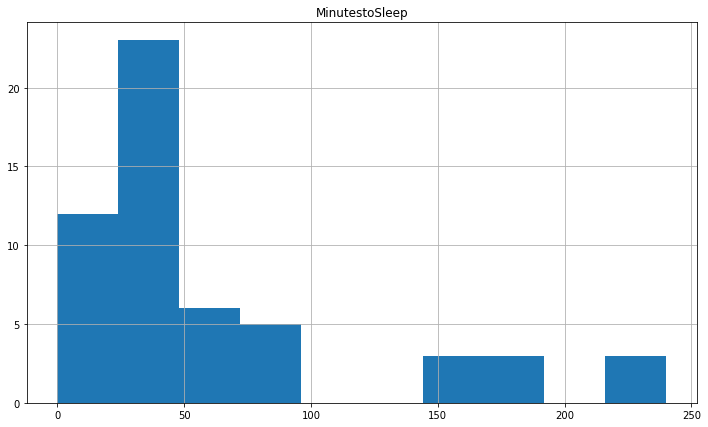

In [26]:
plt.rcParams['figure.figsize'] = (12.0, 7.0)
minutes = pd.DataFrame({"MinutestoSleep":SleepData["TimeToFallAsleepInMinutes"]})
minutes.hist()

In [27]:
SleepData.dtypes

bedTime                      datetime64[ns]
totalInterruptions                    int64
TimeToFallAsleepInMinutes             int64
finalwakeTime                datetime64[ns]
calDate                              object
Time in bed minutes                 float64
Sleeping time in minutes            float64
sleepingtime t-1                    float64
finalwakeTime t-1            datetime64[ns]
dtype: object

#### Interruption values greater than 1 modified to 1
- Our predictor should have a binary output
- Every value greater than 1 was replaced with 1

In [28]:
SleepData.loc[ SleepData['totalInterruptions'] >= 1, 'totalInterruptions'] = 1

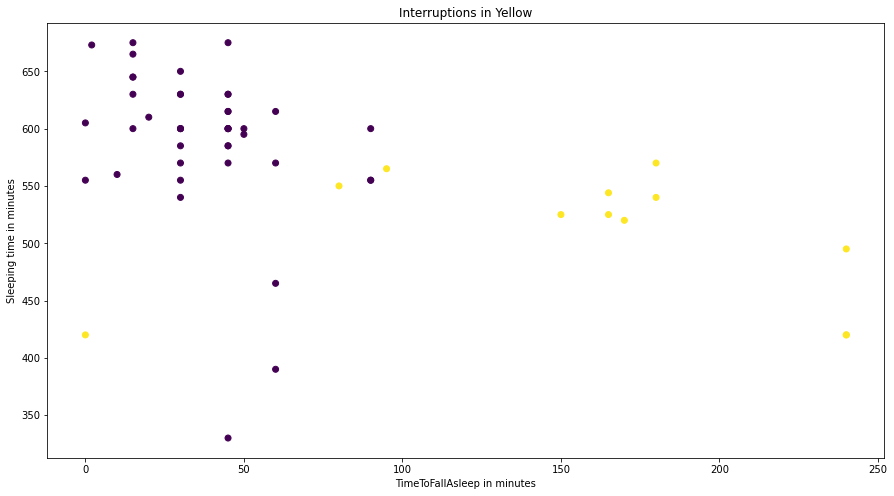

In [29]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(15, 8))

ax.scatter(x=SleepData['TimeToFallAsleepInMinutes'], y=SleepData['Sleeping time in minutes'], c=SleepData['totalInterruptions'])

ax.set(xlabel="TimeToFallAsleep in minutes",
       ylabel="Sleeping time in minutes",
       title="Interruptions in Yellow")
       
plt.show()

### Time to fall asleep and interruptions are both caused by the same exogenous variable. 

-Thats why they show strong serial correlation. 
-Its better to ommit the time to fall asleep, because they very closely related to our predictor.

### Time to merge sleep data with diet

- We will merge using caldate
- A new column will be created which is distance in hours from dinner to bed time
- Check for null values then pick the features which are most relevant
- We will drop null values after merge, because it means the row is missing the whole diet data
- Picking many features will result in overfitting
- It is better to underfit with some bias than pick a model which overfits
- Random forest might have more explanatory power than boosting

In [30]:
TrainingSet = (pd.merge(SleepData, MergedDiet, on='calDate'))

# replacing null values with the mean is a bad idea here
# It means we are replacing a whole row with the mean
# The diet data decreased from 57 to 49

### Model Instability and crossvalidation dataset

- If there isn't any further data (i.e. real application, no simulation), make sure that the model itself is stable (low complexity/highly regularized and/or use an aggregated model): the instability contribution to variance is the one thing here that you can influence and you anyways need to do this, because unstable always means high generalization error. Stability can be checked by iterated/repeated cross validation or out-of-bootstrap validation. 
- In addition, the variance contribution due to model instability cancels out over many runs of the cross/out of bootstrap validation.
- Once you know that this component of the variance is negligible, you can attribute the variance you observe to the finite test sample size. Note that the n is the number of distinct cases that have been tested, regardless of how many runs you did. With that, you can calculate e.g. hereconfidence intervals. Obviously this will not reduce the uncertainty as it is fundamentally caused by too few samples - but it will allow you to judge what you can (or cannot) conclude from your data. With that (possibly + simulations), you may be able to convince you supervisor/boss/customer that more samples are needed.

In [31]:
TrainingSet.head()

,bedTime,totalInterruptions,TimeToFallAsleepInMinutes,finalwakeTime,calDate,Time in bed minutes,Sleeping time in minutes,sleepingtime t-1,finalwakeTime t-1,nf_sugars,nf_total_carbohydrate,nf_calories,Dinner_time,Dinner_sugar,Dinner_carbs,Dinner_calories
0,2022-08-26 21:00:00,0,60,2022-08-27 07:30:00,2022-07-21,630.0,570.0,585.0,2022-08-27 07:15:00,43.000000,125.940000,1120.140000,2022-08-26 18:00:00,13.714544,53.415714,579.749184
1,2022-08-26 22:15:00,0,0,2022-08-27 07:30:00,2022-07-20,555.0,555.0,570.0,2022-08-27 07:30:00,103.380000,250.880000,2593.880000,2022-08-26 18:00:00,23.510000,78.260000,939.480000
2,2022-08-26 21:30:00,0,45,2022-08-27 08:00:00,2022-07-19,630.0,585.0,555.0,2022-08-27 07:30:00,3.700000,43.480000,665.860000,2022-08-26 17:30:00,3.700000,43.480000,665.860000
3,2022-08-26 21:00:00,0,60,2022-08-27 08:15:00,2022-07-15,675.0,615.0,673.0,2022-08-27 08:15:00,50.318338,151.442456,1428.604561,2022-08-26 18:00:00,13.714544,53.415714,579.749184
4,2022-08-26 21:00:00,0,30,2022-08-27 08:20:00,2022-07-14,680.0,650.0,615.0,2022-08-27 08:15:00,46.711404,108.160000,1253.560000,2022-08-26 18:00:00,8.961404,15.370000,266.000000


In [32]:
TrainingSet.shape

(49, 16)

In [33]:
TrainingSet['bedTime minus Dinnertime'] = TrainingSet.apply(lambda x: x['bedTime'] - x['Dinner_time'], axis=1)
TrainingSet['bedTime minus Dinnertime'] = TrainingSet['bedTime minus Dinnertime'].astype('timedelta64[m]')

TrainingSet['finalwakeTime t-1'] = TrainingSet.apply(lambda x: x['finalwakeTime t-1'] - x['finalwakeTime t-1'].normalize(), axis=1)
TrainingSet['finalwakeTime t-1'] = TrainingSet['finalwakeTime t-1'].astype('timedelta64[m]')

In [34]:
TrainingSet = TrainingSet.drop(['bedTime', 'calDate', 'TimeToFallAsleepInMinutes', 'Time in bed minutes', 'Sleeping time in minutes', 'finalwakeTime', 'Dinner_time', 'nf_sugars','Dinner_carbs'], axis=1)

In [35]:
TrainingSet.head()
TrainingSet.reset_index(drop=True)

,totalInterruptions,sleepingtime t-1,finalwakeTime t-1,nf_total_carbohydrate,nf_calories,Dinner_sugar,Dinner_calories,bedTime minus Dinnertime
0,0,585.0,435.0,125.940000,1120.140000,13.714544,579.749184,180.0
1,0,570.0,450.0,250.880000,2593.880000,23.510000,939.480000,255.0
2,0,555.0,450.0,43.480000,665.860000,3.700000,665.860000,240.0
3,0,673.0,495.0,151.442456,1428.604561,13.714544,579.749184,180.0
4,0,615.0,495.0,108.160000,1253.560000,8.961404,266.000000,180.0
5,0,650.0,500.0,137.200000,1142.020000,11.300000,639.530000,180.0
6,0,600.0,510.0,115.330000,1971.260000,6.311404,550.680000,180.0
7,1,630.0,495.0,269.000000,2603.190000,22.510000,1277.420000,210.0
8,1,420.0,270.0,218.640000,2405.160000,10.490000,717.660000,180.0
9,0,495.0,555.0,312.100000,2792.070000,7.480000,913.820000,180.0


### Prepare the data for the model
- Create bins or buckets for our features
- Making catagorical variables helps while using trees

array([[<AxesSubplot:title={'center':'Wake Up Time yesterday'}>,
        <AxesSubplot:title={'center':'Bed minus Dinner in minutes'}>]],
      dtype=object)

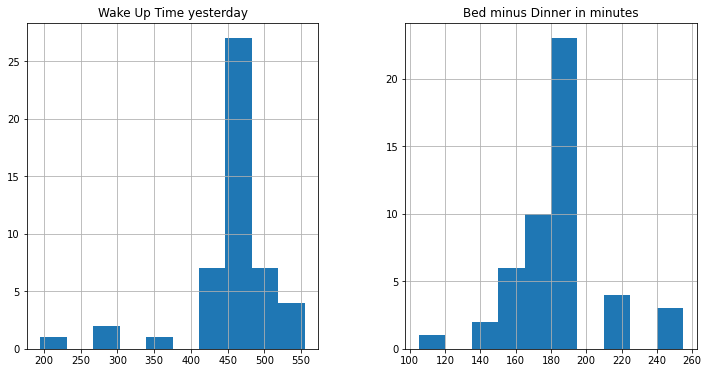

In [36]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
histo = pd.DataFrame({"Wake Up Time yesterday":TrainingSet["finalwakeTime t-1"], "Bed minus Dinner in minutes":TrainingSet["bedTime minus Dinnertime"]})
histo.hist()

array([[<AxesSubplot:title={'center':'Calories total'}>,
        <AxesSubplot:title={'center':'Dinner Calories'}>]], dtype=object)

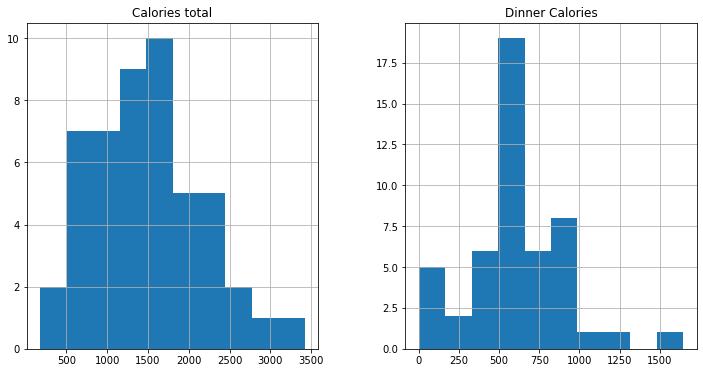

In [37]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
histo = pd.DataFrame({"Calories total":TrainingSet["nf_calories"], "Dinner Calories":TrainingSet["Dinner_calories"]})
histo.hist()

<AxesSubplot:xlabel='totalInterruptions', ylabel='count'>

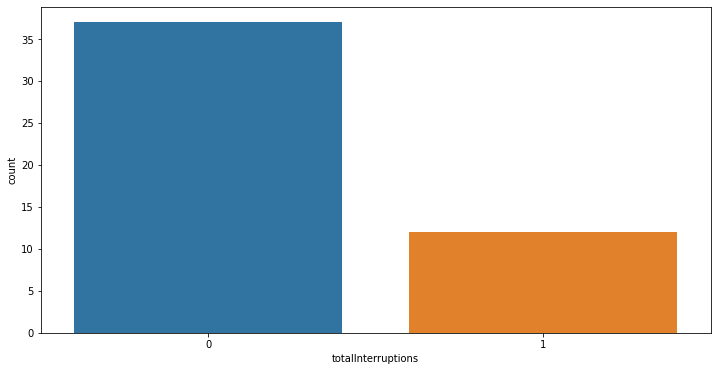

In [38]:
import seaborn as sns

sns.countplot(data = TrainingSet, x = 'totalInterruptions')

In [39]:
# Creating time buckets bed minus dinner
TrainingSet.loc[ TrainingSet['bedTime minus Dinnertime'] <= 120, 'bedTime minus Dinnertime'] = 0
TrainingSet.loc[(TrainingSet['bedTime minus Dinnertime'] > 120) & (TrainingSet['bedTime minus Dinnertime'] <= 170), 'bedTime minus Dinnertime'] = 1
TrainingSet.loc[(TrainingSet['bedTime minus Dinnertime'] > 170) & (TrainingSet['bedTime minus Dinnertime'] <= 200), 'bedTime minus Dinnertime'] = 2
TrainingSet.loc[(TrainingSet['bedTime minus Dinnertime'] > 200) & (TrainingSet['bedTime minus Dinnertime'] <= 230), 'bedTime minus Dinnertime'] = 3
TrainingSet.loc[ TrainingSet['bedTime minus Dinnertime'] > 230, 'bedTime minus Dinnertime'] = 4 

In [40]:
TrainingSet

,totalInterruptions,sleepingtime t-1,finalwakeTime t-1,nf_total_carbohydrate,nf_calories,Dinner_sugar,Dinner_calories,bedTime minus Dinnertime
0,0,585.0,435.0,125.940000,1120.140000,13.714544,579.749184,2.0
1,0,570.0,450.0,250.880000,2593.880000,23.510000,939.480000,4.0
2,0,555.0,450.0,43.480000,665.860000,3.700000,665.860000,4.0
3,0,673.0,495.0,151.442456,1428.604561,13.714544,579.749184,2.0
4,0,615.0,495.0,108.160000,1253.560000,8.961404,266.000000,2.0
5,0,650.0,500.0,137.200000,1142.020000,11.300000,639.530000,2.0
6,0,600.0,510.0,115.330000,1971.260000,6.311404,550.680000,2.0
7,1,630.0,495.0,269.000000,2603.190000,22.510000,1277.420000,3.0
8,1,420.0,270.0,218.640000,2405.160000,10.490000,717.660000,2.0
9,0,495.0,555.0,312.100000,2792.070000,7.480000,913.820000,2.0


<AxesSubplot:>

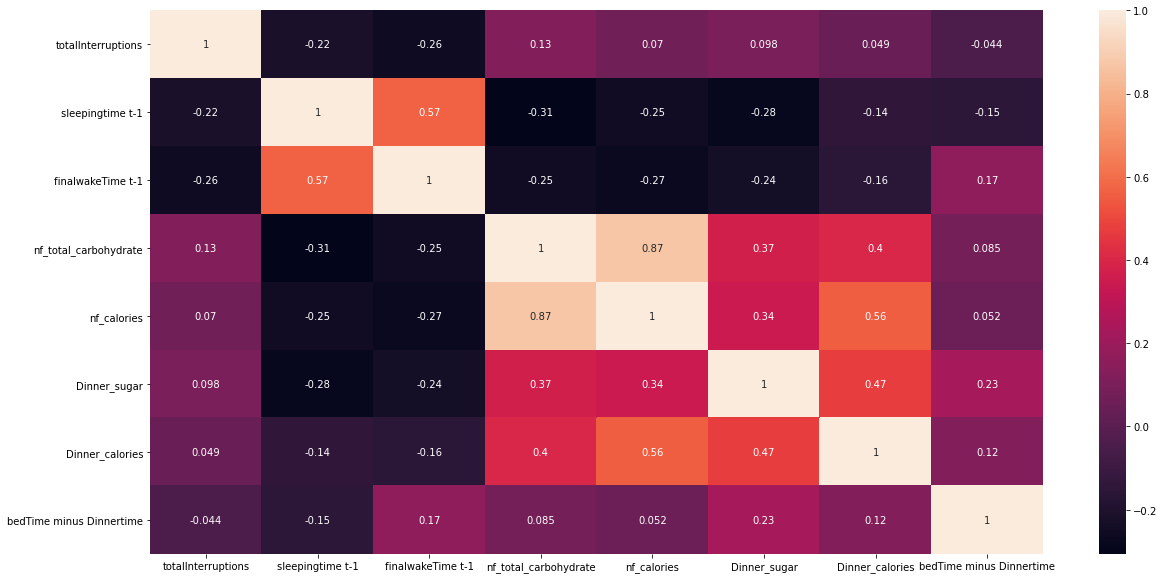

In [41]:
# Total calorie intake doesnt seem to effect interruptions
# Interruptions is negatively correlated with a late wake time the morning before
# More hours from dinner is negatively correlated to interruptions which is expected
# Sleeping time and wake time are highly correlated so we should drop one of these features

#TrainingSet['Dinner Sugar and time'] = TrainingSet['Dinner_sugar']/(np.log1p(TrainingSet['bedTime minus Dinnertime']))
#TrainingSet['Carbs and time'] = TrainingSet['Dinner_calories']/(np.log1p(TrainingSet['bedTime minus Dinnertime']))
                                        
plt.figure(figsize=(20,10))
sns.heatmap(TrainingSet.corr(),annot=True)

In [42]:
TrainingSet = pd.get_dummies(TrainingSet, columns=['bedTime minus Dinnertime'])

In [43]:
TrainingSet['Dinner_sugar'] = pd.qcut(TrainingSet['Dinner_sugar'], 5)
TrainingSet['sleepingtime t-1'] = pd.qcut(TrainingSet['sleepingtime t-1'], 5)
TrainingSet['finalwakeTime t-1'] = pd.qcut(TrainingSet['finalwakeTime t-1'], 5)
TrainingSet['nf_total_carbohydrate'] = pd.qcut(TrainingSet['nf_total_carbohydrate'], 5)
TrainingSet['nf_calories'] = pd.qcut(TrainingSet['nf_calories'], 5)
TrainingSet['Dinner_calories'] = pd.qcut(TrainingSet['Dinner_calories'], 5)

In [44]:
TrainingSet = pd.get_dummies(TrainingSet, drop_first = True)
TrainingSet

,totalInterruptions,bedTime minus Dinnertime_0.0,bedTime minus Dinnertime_1.0,bedTime minus Dinnertime_2.0,bedTime minus Dinnertime_3.0,bedTime minus Dinnertime_4.0,"sleepingtime t-1_(534.0, 570.0]","sleepingtime t-1_(570.0, 600.0]","sleepingtime t-1_(600.0, 630.0]","sleepingtime t-1_(630.0, 675.0]",...,"nf_calories_(1593.478, 1993.596]","nf_calories_(1993.596, 3420.95]","Dinner_sugar_(4.24, 9.067]","Dinner_sugar_(9.067, 13.715]","Dinner_sugar_(13.715, 16.04]","Dinner_sugar_(16.04, 63.69]","Dinner_calories_(440.85, 573.058]","Dinner_calories_(573.058, 592.838]","Dinner_calories_(592.838, 830.52]","Dinner_calories_(830.52, 1645.44]"
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
6,0,0,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
7,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
8,1,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
9,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1


In [45]:
# We can normalize both dinner sugar and dinner calories by dividing them with the time from bed time
# This is an option for later on


from sklearn.model_selection import train_test_split

X = TrainingSet.drop('totalInterruptions', axis=1)
y = TrainingSet.totalInterruptions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [46]:
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=7, learning_rate=0.1, random_state=0)

# Train Adaboost Classifer
model1 = abc.fit(X_train, y_train)


#Predict the response for test dataset
y_pred = model1.predict(X_test)

In [47]:
#import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score


# calculate and print model accuracy
print("AdaBoost Classifier Model Accuracy:", accuracy_score(y_test, y_pred))

from sklearn.model_selection import cross_val_score

# Calculating cross-validation of the training model
print ('Calculating cross-validation of the training model. Please WAIT ...')

# Cross-validation with k-fold of 5. So this will randomly split the training data into two sets.
# It then fits a model to one set and tests it against the other to get an accuracy.
# It will do this 5 times and return the average accuracy.
scores = cross_val_score(model1, X_train, y_train, cv=5)
print ( 'On average, this model is correct {:0.2f}% (+/- {:0.2f}%) of the time.'.format(
        scores.mean() * 100.0, scores.std() * 2 * 100.0))

sum(y == 0)/len(y)

AdaBoost Classifier Model Accuracy: 0.8
Calculating cross-validation of the training model. Please WAIT ...
On average, this model is correct 66.43% (+/- 21.48%) of the time.


0.7551020408163265

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

n_estimators = [150, 100, 20, 30, 40, 50];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_r = [0.1, 0.3, 0.5, 1, 2]

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
grid = GridSearchCV(AdaBoostClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X_train,y_train) 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 1, 2],
                         'n_estimators': [150, 100, 20, 30, 40, 50]})

In [49]:
grid.best_score_

0.675

In [50]:
grid.best_params_

{'learning_rate': 0.5, 'n_estimators': 20}

In [51]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[7 0]
 [2 1]]


Text(69.0, 0.5, 'truth')

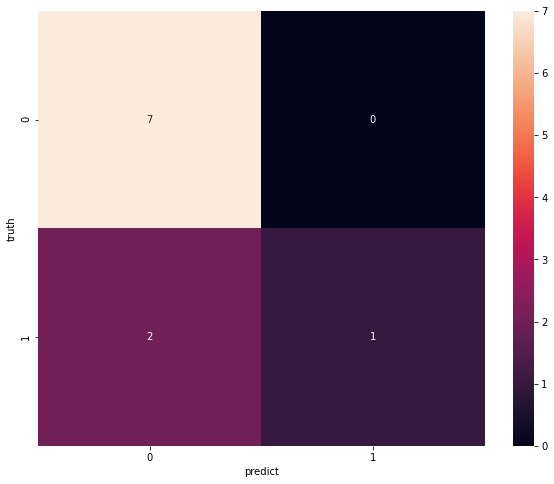

In [52]:
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot= True)
plt.xlabel('predict')
plt.ylabel('truth')

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.67      0.69        10
weighted avg       0.84      0.80      0.76        10



DecisionTree Classifier Model Accuracy: 0.8
On average, this model is correct 64.29% (+/- 30.39%) of the time.


'test.pdf'

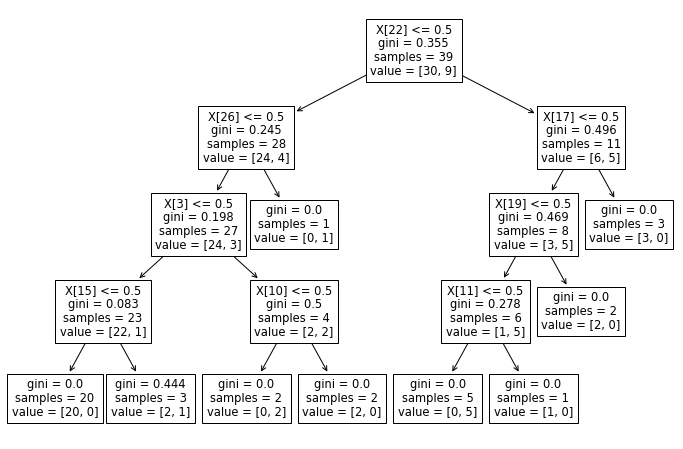

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


dt = DecisionTreeClassifier( random_state=1, max_depth = 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modeltree = dt.fit(X_train, y_train)
y_pred = modeltree.predict(X_test)


# calculate and print model accuracy
print("DecisionTree Classifier Model Accuracy:", accuracy_score(y_test, y_pred))

scores = cross_val_score(modeltree, X_train, y_train, cv=7)
print ( 'On average, this model is correct {:0.2f}% (+/- {:0.2f}%) of the time.'.format(
        scores.mean() * 100.0, scores.std() * 2 * 100.0))


plt.figure(figsize=(12,8))


tree.plot_tree(modeltree.fit(X_train, y_train)) 

import graphviz

dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") # name of the file to which you want save

dot_data = tree.export_graphviz(dt, # classification model that need to be plotted
                                out_file=None, 
                                feature_names=X.columns, # feature names / names of the dataframe column (df.columns)  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  


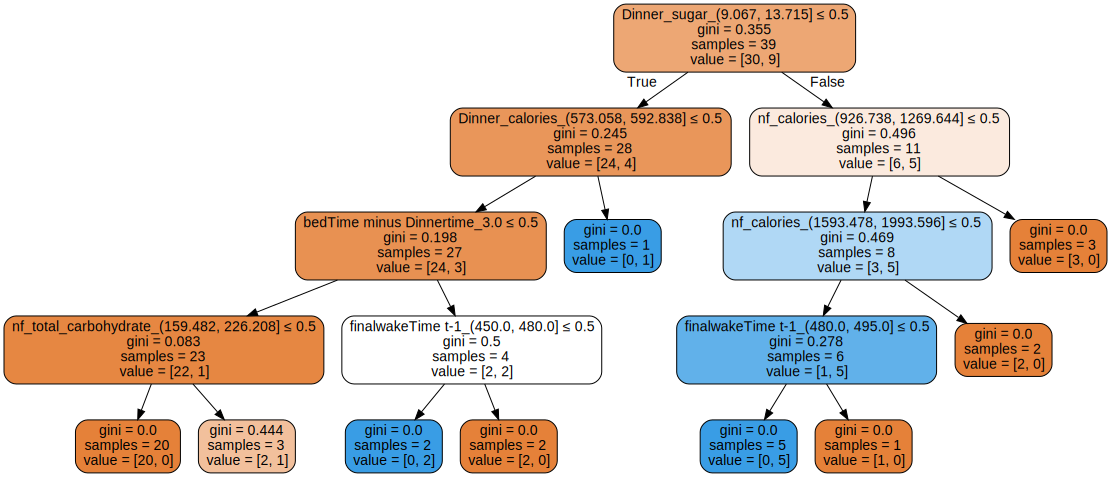

In [55]:
graph